In [49]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk
import warnings
warnings.filterwarnings('ignore')

nltk.download('gutenberg')
!python -m spacy download en

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\hafeez_poldz\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
symbolic link created for C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\en_core_web_sm
[+] Linking successful
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\hafeez_poldz\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.

**Note**: Since processing all the text takes around ~5-10 minutes, in the cell below we are taking only the first tenth of each text. If you want to experiment, feel free to change the following code in the next cell:

```python
alice = text_cleaner(alice[:int(len(alice)/10)])
persuasion = text_cleaner(persuasion[:int(len(persuasion)/10)])
```
to 

```python
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)
```

In [50]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice[:int(len(alice)/10)])
persuasion = text_cleaner(persuasion[:int(len(persuasion)/10)])

In [51]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load("en")
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [52]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(Oh, dear, !)",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [53]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [54]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400


,observance,mercy,faculty,poor,dip,claim,rejoin,agreeable,believe,9,...,expedient,hope,issue,think,deal,consideration,advice,thing,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll


## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [55]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.981203007518797

Test set score: 0.8539325842696629


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [56]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9699248120300752

Test set score: 0.8764044943820225


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [57]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9661654135338346

Test set score: 0.8089887640449438


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data. Remember that for computation time concerns, we only took the first tenth of the Alice text. Emma is pretty long. **So in order to get comparable length texts, we take the first sixtieth of Emma**. Again, if you want to experiment, you can take the whole texts of each.

In [58]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma[:int(len(emma)/60)])
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [59]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [60]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

emma_sents

[[Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.,
  'Austen'],
 [She was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.,
  'Austen'],
 [Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection.,
  'Austen'],
 [Sixteen years had Miss Taylor been in Mr. Woodhouse's family, less as a governess than a friend, very fond of both daughters, but particularly of Emma.,
  'Austen'],
 [Between _them, 'Austen'],
 [_, 'Austen'],
 [it was more the intimacy of sisters., 'Austen'],
 [Even before Miss Taylor had ceased t

In [61]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 50
Processing row 100
Processing row 150
done


In [62]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.7235772357723578


col_0,Austen,Carroll
row_0,,
Austen,158,12
Carroll,56,20


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 93%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 90%.  

## Model 1. SVC


In [63]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
print('Train set acc: ', model.score(X_train, y_train))
print('Test set acc: ', model.score(X_test, y_test))


Train set acc:  0.7142857142857143
Test set acc:  0.702247191011236


## Model 2. Logistic Classifier (Lasso)

In [16]:
lr = LogisticRegression(penalty='l1', C=1, solver = 'saga') # No need to specify l2 as it's the default. But we put it for demonstration.
lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
cvs = cross_val_score(lr, X_train, y_train, cv = 5)
print('Cross-validation acc: mean {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

Training set score: 0.8872180451127819

Test set score: 0.8314606741573034
Cross-validation acc: mean 0.8157931516422083, std: 0.014001375023192947


## Model 3. XGBOOST Classifier

In [65]:
import xgboost as xgb
max_depth = [3, 4, 5, 6]
estimators = [100, 150, 200,]
learning_rate = [0.1, 0.2, 0.3]
colsample = [0.1, 0.2, 0.3]

params = dict(max_depth = max_depth, n_estimators = estimators, 
              learning_rate = learning_rate, colsample_bylevel = colsample)

gs = GridSearchCV(xgb.XGBClassifier(), params, cv = 5)
gs.fit(X_train, y_train)
gs.best_params_

{'colsample_bylevel': 0.2,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100}

In [66]:
xgb = xgb.XGBClassifier(**gs.best_params_)
xgb.fit(X_train, y_train)
print('Training set score:', xgb.score(X_train, y_train))
print('\nTest set score:', xgb.score(X_test, y_test))
cvs = cross_val_score(xgb, X_train, y_train, cv = 5)
print('Cross-validation acc: mean {}, std: {}'.format(np.mean(cvs), np.std(cvs)))

Training set score: 0.8796992481203008

Test set score: 0.8202247191011236
Cross-validation acc: mean 0.8082459818308875, std: 0.022167216092698065



# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

In [67]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [68]:
# load the book
paradise = gutenberg.raw('milton-paradise.txt')
print('\nRaw:\n', paradise[0:100])


Raw:
 [Paradise Lost by John Milton 1667] 
 
 
Book I 
 
 
Of Man's first disobedience, and the fruit 
Of 


In [69]:
# clean the chapter
paradise = re.sub(r'Book .*', "", paradise)
print(paradise[:100])

[Paradise Lost by John Milton 1667] 
 
 

 
 
Of Man's first disobedience, and the fruit 
Of that fo


In [70]:
# clean the novel
paradise = text_cleaner(paradise[:int(len(paradise)/10)])

# parse the cleaned novel
paradise_doc = nlp(paradise)

# group into sentences
paradise_sents = [[sent, 'Milton'] for sent in paradise_doc.sents]

# equalize with the lenght of Alice
paradise_sents = paradise_sents[:len(alice_sents)]

# create a dataframe
paradise_sents = pd.DataFrame(paradise_sents)

# the same common words from Alice and Persuasion.
paradise_bow = bow_features(paradise_sents, common_words)

Processing row 0
Processing row 50
Processing row 100


In [71]:
# define test sets for Paradise
par_X_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    paradise_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
par_y_test = pd.concat([y_train[y_train == 'Carroll'], pd.Series(['Milton']*paradise_bow.shape[0])])

In [72]:
# logistic classifier
lr = LogisticRegression()
lr.fit(par_X_test, par_y_test)
print('\nTest set score:', lr.score(par_X_test, par_y_test))
cvs = cross_val_score(lr, par_X_test, par_y_test, cv = 5)
print('Cross-validation acc: mean {}, std: {}'.format(np.mean(cvs), np.std(cvs)))
y_pred = lr.predict(par_X_test)


Test set score: 0.9512195121951219
Cross-validation acc: mean 0.7610278745644599, std: 0.046737832274326936


             precision    recall  f1-score   support

    Carroll       1.00      0.87      0.93        76
     Milton       0.93      1.00      0.96       129

avg / total       0.95      0.95      0.95       205



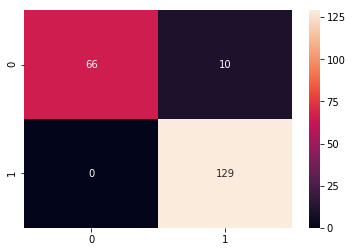

In [73]:
# confusion matrix and classification report
print(classification_report(par_y_test,y_pred))
sns.heatmap(confusion_matrix(par_y_test,y_pred),annot=True,fmt='d')
plt.show()

# Conclusion
SVC model with default parameters did not improve the accuracy. However, Logistic classifier with Lasso regularization gave the best results even compared to the results obtained from XGBoost classifier. 
I tested the model to see if model is able to identify Alice in Wonderland versus Paradise novel by Milton. From the report we can see that the model is able to classify Milton's Paradise better than Alice in wonderland with recall score 1. and 